In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [76]:
from PIL import Image
from tensorflow.keras.utils import to_categorical

In [77]:
data_dir = "./Kannada-MNIST/"

In [78]:
# data_dir = "/kaggle/input/Kannada-MNIST/"
train = pd.read_csv(data_dir + "train.csv")
train.shape

(60000, 785)

In [79]:
test = pd.read_csv(data_dir + "test.csv")
test.shape

(5000, 785)

In [80]:
X_train_ = train.iloc[:,1:]
y_train_ = train.iloc[:,0]
X_test_ = test.iloc[:,1:]

In [81]:
def oneD_to_threeD(images, labels, row_number, shape=28):
    images = images.iloc[0:row_number,:].values #取出部分数据（此处500）并转为uint8格式方便CV处理
    labels = labels.iloc[0:row_number]
    train_data = []
    for i in range(row_number):
        img = images[i,:]
        img = img.reshape(28, 28) #reshape为2维矩阵
        img = Image.fromarray(img.astype('uint8')).convert('RGB') #转化为image方便resize并转化为三通道图像
        resized_img = img.resize((shape,shape), Image.ANTIALIAS) #resize到需要的尺寸
        resized_img = np.array(resized_img).astype('float32') #重新转化为array以输入神经网络
        train_data.append(resized_img)
    train_data=np.array(train_data).astype('float32') #转为float32格式方便神经网络识别
    labels = to_categorical(labels) #标签化label
    return train_data, labels

In [82]:
X_train, y_train= oneD_to_threeD(X_train_, y_train_, 5000)

In [83]:
X_train.shape

(5000, 28, 28, 3)

In [84]:
y_train.shape

(5000, 10)

In [85]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
import cv2

In [87]:
def reshape_28_to_96(images):
    data = []
    for i in range(len(images)):
        width = 96
        height = 96
        dim = (width, height)
        # resize image
        resized = cv2.resize(images[i], dim, interpolation = cv2.INTER_AREA)
        resized_img = np.array(resized).astype('float32') 
        data.append(resized_img)
    data=np.array(data).astype('float32') 
    return data

In [88]:
X_train = reshape_28_to_96(X_train)

In [89]:
from sklearn.model_selection import train_test_split
X_train,X_vali, y_train, y_vali = train_test_split(X_train,
                                                   y_train,
                                                   test_size = 0.2)

print(X_train.shape, X_vali.shape, y_train.shape, y_vali.shape)

(4000, 96, 96, 3) (1000, 96, 96, 3) (4000, 10) (1000, 10)


In [96]:
# plt.imshow(X_train[200])

In [97]:
base_model = keras.applications.MobileNetV2(weights = 'imagenet', input_shape = (96, 96, 3), include_top = False)

In [98]:
base_model.trainable = False

In [99]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), 
    Dropout(0.4), 
    Dense(10, activation = 'softmax')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [100]:
optimizer = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(optimizer=optimizer,
              loss=['categorical_crossentropy'],
              metrics=['accuracy'])

In [101]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1)

In [102]:
datagen.fit(X_train)

In [103]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, verbose = 1,
                              patience=3, min_lr=0.00001)

In [106]:
epochs = 30
batch_size = 64
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, 
                    steps_per_epoch=len(X_train) // batch_size, verbose = 2,
                    validation_data=(X_vali, y_vali), callbacks=[reduce_lr])

Epoch 1/30
62/62 - 17s - loss: 0.2649 - accuracy: 0.9158 - val_loss: 0.1977 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 2/30
62/62 - 17s - loss: 0.2433 - accuracy: 0.9248 - val_loss: 0.1839 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 3/30
62/62 - 17s - loss: 0.2092 - accuracy: 0.9365 - val_loss: 0.1615 - val_accuracy: 0.9510 - lr: 0.0010
Epoch 4/30
62/62 - 17s - loss: 0.2160 - accuracy: 0.9355 - val_loss: 0.1549 - val_accuracy: 0.9520 - lr: 0.0010
Epoch 5/30
62/62 - 17s - loss: 0.2002 - accuracy: 0.9342 - val_loss: 0.1597 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 6/30
62/62 - 17s - loss: 0.1928 - accuracy: 0.9383 - val_loss: 0.1549 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 7/30

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
62/62 - 17s - loss: 0.2116 - accuracy: 0.9332 - val_loss: 0.1568 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 8/30
62/62 - 18s - loss: 0.1664 - accuracy: 0.9474 - val_loss: 0.1342 - val_accuracy: 0.9570 - lr: 5.0000e-04
Epoch 9/30
62/62 - 

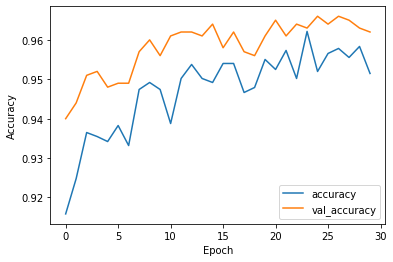

In [107]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [108]:
# X_test, y_train= oneD_to_threeD(X_test_, y_train_, 5000)

In [109]:
# X_test = reshape_28_to_96(X_test)

In [110]:
# predicted = model.predict(X_test)